In [1]:
from xml.etree import ElementTree as ET
from datetime import timedelta, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def parse_time_delta(time_str):
    t = datetime.strptime(time_str,"%H:%M:%S")
    
    delta = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)
    return delta

def parse_time(time_str):
    t = datetime.strptime(time_str,"%H:%M:%S")
    
    return t.time()

In [2]:
output_figure_path = "/Users/clemens/Documents/courses/abmt/projects/abmt_project/report/figures"

In [3]:
dev_figsize=(6,6)

In [4]:
def get_link_ids(path="/Users/clemens/Documents/courses/abmt/projects/abmt_project/analysis/network_analysis/link_ids_to_delete_raw.txt"):
    with open(path, "r") as f:
        l = list(f.readlines())
    return [s.rstrip('\n') for s in l]
links_to_delete = get_link_ids()

In [5]:
def travel_minutes_from_file(path):
    tree = ET.parse(path)
    
    all_travel_times = [parse_time_delta(l.get('trav_time')) for l in tree.findall("./person/plan/leg[@mode='car']")]
    all_travel_time_minutes = [t/timedelta(minutes=1) for t in all_travel_times]
    return np.array(all_travel_time_minutes)

In [6]:
def expirienced_plans_to_trips(path):
    tree = ET.parse(path)
    
    indexx = list()
    
    person_idss = list()
    dep_timess = list()
    trav_timess = list()
    start_linkss = list()
    end_linkss = list()
    routess = list()
    
    for person in tree.findall("./person"):
        person_id = person.get("id")
        for plan in person.findall("plan/leg[@mode='car']"):
            dep_time = plan.get("dep_time")
            
            index_string = "{}@{}".format(person_id, dep_time)
            indexx.append(index_string)
            
            trav_time = parse_time_delta(plan.get("trav_time"))
            routes = plan.findall("route")
            assert(len(routes)==1)
            start_link = routes[0].get("start_link")
            end_link = routes[0].get("end_link")
            route_links = routes[0].text
#             print(route_links)
            
            
            person_idss.append(person_id)
            dep_timess.append(dep_time)
            trav_timess.append(trav_time)
            start_linkss.append(start_link)
            end_linkss.append(end_link)
            routess.append(route_links)
    
#     print(routess)       
    return pd.DataFrame(index = indexx, data={'person_id': person_idss, 'dep_time': dep_timess, 'trav_time': trav_timess, "start_link":start_linkss, 
                                              "end_link": end_linkss, "route": routess})

def trip_ids_by_contained_route(path, deleted_links=links_to_delete, min_hits=1):
    tree = ET.parse(path)
    indexx = list()
    n_affected_linksss = list()
    
    filter_link_set = set(deleted_links)
    
    for person in tree.findall("./person"):
        person_id = person.get("id")
        for plan in person.findall("plan/leg[@mode='car']"):
            
            routes = plan.findall("route")
            assert(len(routes)==1)
            route = routes[0]
            if route.text is not None:
                individual_links = route.text.split(" ")
                link_set = set(individual_links)
            
                filter_links_in_current_route = link_set.intersection(filter_link_set)
                
                n =len(filter_links_in_current_route)
                if(n >= min_hits):
#                     print(filter_links_in_current_route)
            
                    dep_time = plan.get("dep_time")            
                    index_string = "{}@{}".format(person_id, dep_time)
#                     print(index_string)
                    indexx.append(index_string)
                    n_affected_linksss.append(n)
    return pd.DataFrame(index=indexx, data={'n_deleted_links':n_affected_linksss})



In [7]:
path_original_higher_capacity = "/Users/clemens/Documents/courses/abmt/projects/abmt_project/simulations/original_higher_capacity_factors/simulation_output/"\
    + "output_experienced_plans.xml"

path_original_freeflow_times_params = "/Users/clemens/Documents/courses/abmt/projects/abmt_project/simulations/original/ile_de_france_population_diluted_caronly.xml"

path_slowed_down_roads = "/Users/clemens/Documents/courses/abmt/projects/abmt_project/simulations/road_deleted/simulation_output/output_experienced_plans.xml"

deleted_link_ids = "/Users/clemens/Documents/courses/abmt/projects/abmt_project/analysis/network_analysis/link_ids.xml"

trips_original_freeflow_times = expirienced_plans_to_trips(path_original_freeflow_times_params)
trips_original_higher_capacity = expirienced_plans_to_trips(path_original_higher_capacity)
trips_slowed_down_roads = expirienced_plans_to_trips(path_slowed_down_roads)

ids_of_trips_through_deleted_link = trip_ids_by_contained_route(path_original_higher_capacity, min_hits=2)

Mean: 10.6 minutes; Median: 8.2 minutes
Mean: 22.1 minutes; Median: 17.8 minutes
Mean: 23.1 minutes; Median: 18.2 minutes


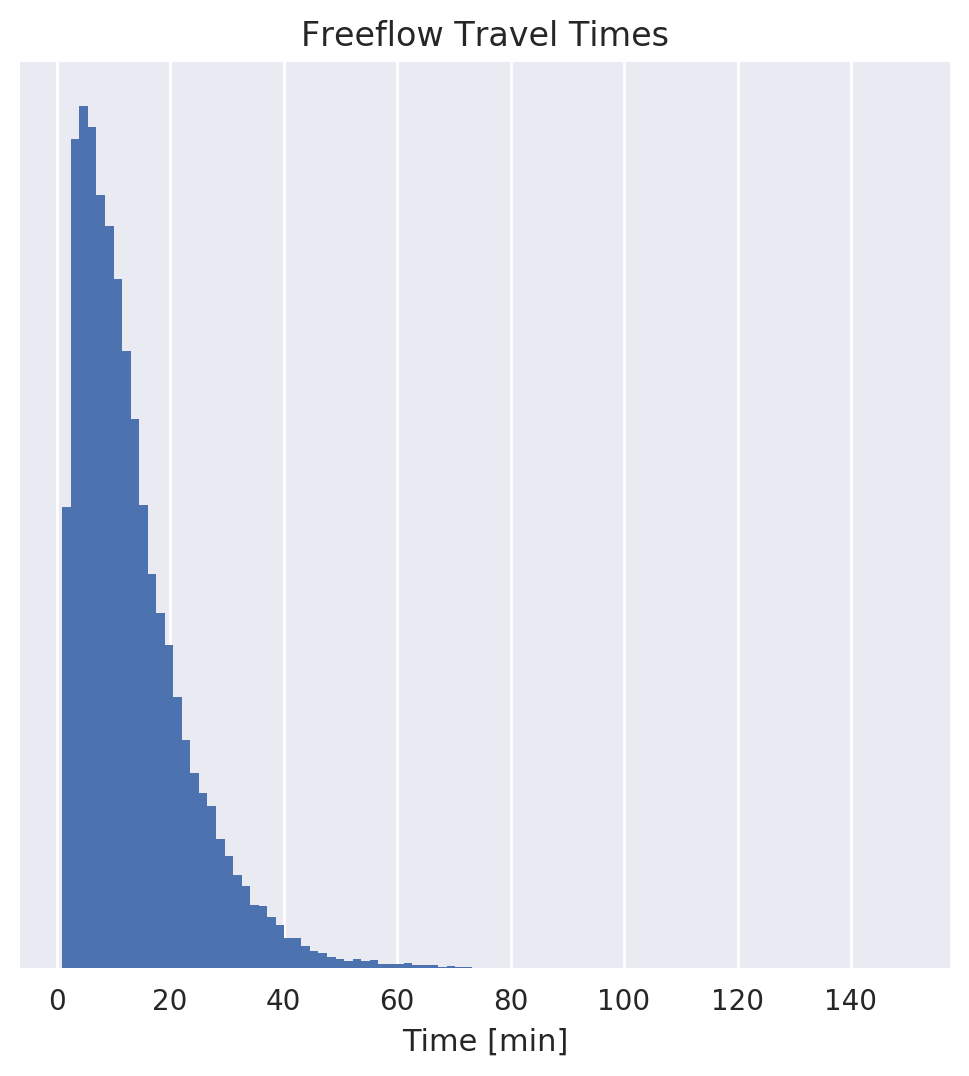

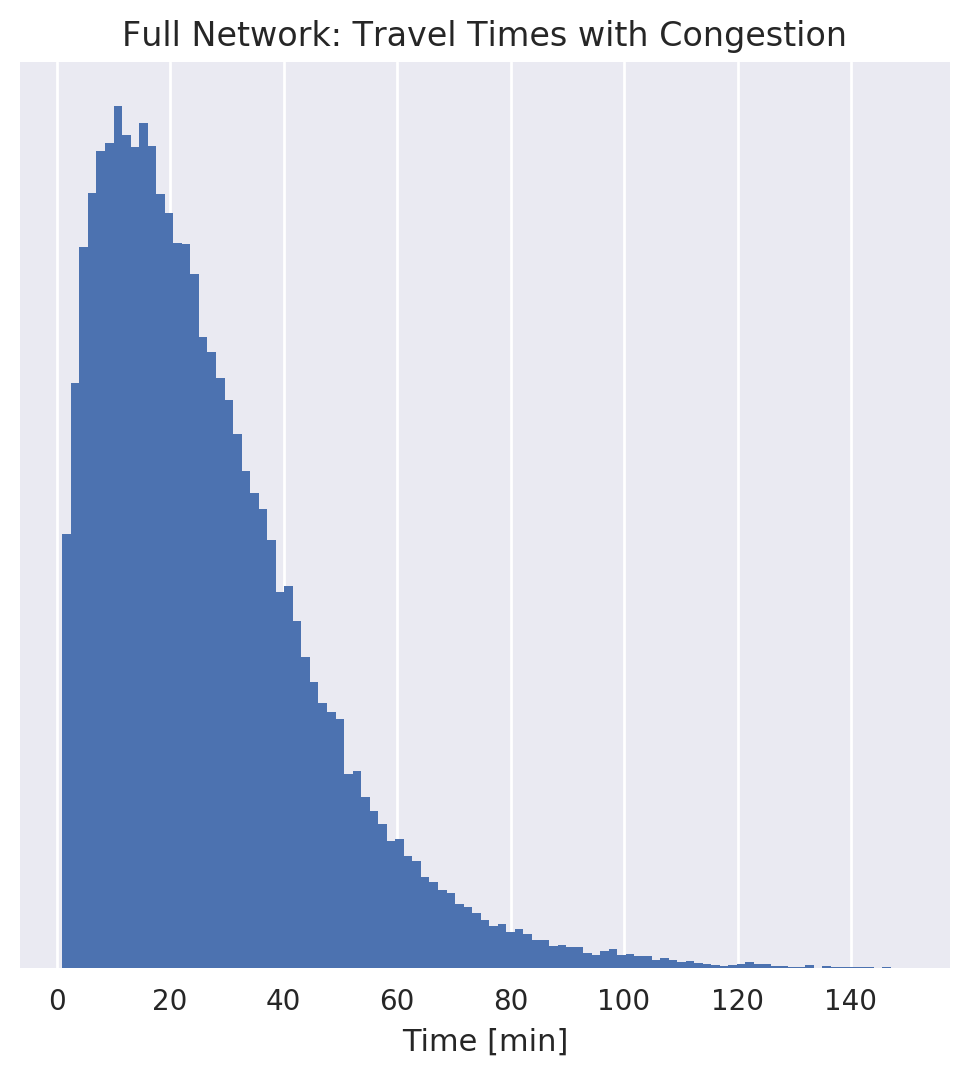

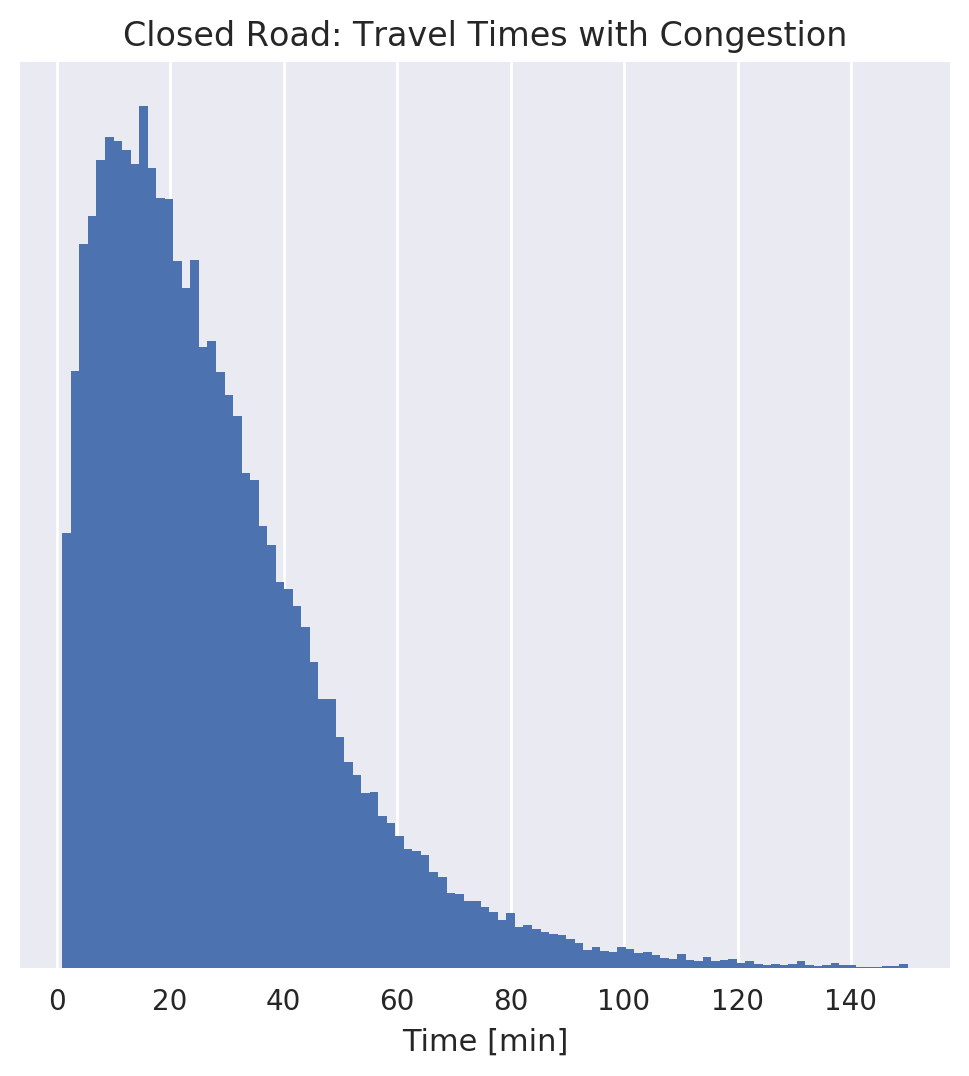

In [8]:
def histogram_of_travel_times(df, bins=100, title=None, nr=-1):
    fig,ax = plt.subplots(dpi=200, figsize=dev_figsize)
    times = [t/timedelta(minutes=1) for t in df.trav_time]
    print("Mean: {:.1f} minutes; Median: {:.1f} minutes".format(np.nanmean(times), np.nanmedian(times)))
    ax.get_yaxis().set_visible(False)
    ax.hist(times, bins)
    plt.xlabel("Time [min]")
    ax.set_title(title)
    file_path = "{}/Figure {} - {}".format(output_figure_path, nr, title)
    fig.savefig(file_path)

plt.style.use('seaborn')
bins=np.linspace(1, 150, 100)
histogram_of_travel_times(trips_original_freeflow_times, bins=bins, 
                          title="Freeflow Travel Times", nr="1a")
histogram_of_travel_times(trips_original_higher_capacity, bins=bins, 
                         title="Full Network: Travel Times with Congestion", nr="1b")
histogram_of_travel_times(trips_slowed_down_roads, bins=bins,
                         title="Closed Road: Travel Times with Congestion", nr="2a")

In [9]:
def relative_times(smaller, bigger, smaller_threshold_value = -1, bigger_threshold_value=-1):
    smaller_seconds = smaller.trav_time / timedelta(seconds=1)
    smaller_seconds = smaller_seconds[smaller_seconds >= smaller_threshold_value]
    bigger_seconds = bigger.trav_time / timedelta(seconds=1)
    bigger_seconds = bigger_seconds[bigger_seconds >= bigger_threshold_value]
    ratio = bigger_seconds / smaller_seconds
    assert(np.all(np.isfinite(smaller_seconds)))
    assert(np.all(np.isfinite(bigger_seconds)))
    assert(np.all(smaller_seconds!=0))
#     assert(bigger_seconds.index == smaller_seconds.index)
    finite_ratio = ratio[np.isfinite(ratio)]
    print("{} trips were not matched".format(len(ratio)-len(finite_ratio)))
    return finite_ratio

In [10]:
def histogram_of_ratios(smaller, bigger, smaller_threshold_value=60, bigger_threshold_value=60, bins=100, title=None, nr=-1):
    ratio = relative_times(smaller, bigger, smaller_threshold_value=smaller_threshold_value, bigger_threshold_value=bigger_threshold_value)
#     return ratio
    fig, ax = plt.subplots(figsize=dev_figsize, dpi=200)
    ratios_changed_filter = ratio !=1
    fraction_changed = np.mean(ratios_changed_filter)
    ratio_changed = ratio[ratios_changed_filter]
    mean = np.nanmean(ratio_changed)
    median = np.nanmedian(ratio_changed)
    print("{} percent of trips changed, mean: {}, median: {}".format(fraction_changed, mean, median))
    ax.hist(ratio_changed*100, bins=bins*100)
    plt.axvline(100, color='red')
    plt.xlabel("Relative Travel Time Increase [%]")
    
    ax.get_yaxis().set_visible(False)
    ax.set_title(title)
    file_path = "{}/Figure {} - {}".format(output_figure_path, nr, title)
    fig.savefig(file_path)


#     print('mean time indrease: {}'.format(ratio.mean()))
    



8067 trips were not matched
1.0 percent of trips changed, mean: 2.495412236786716, median: 1.8360949878421837


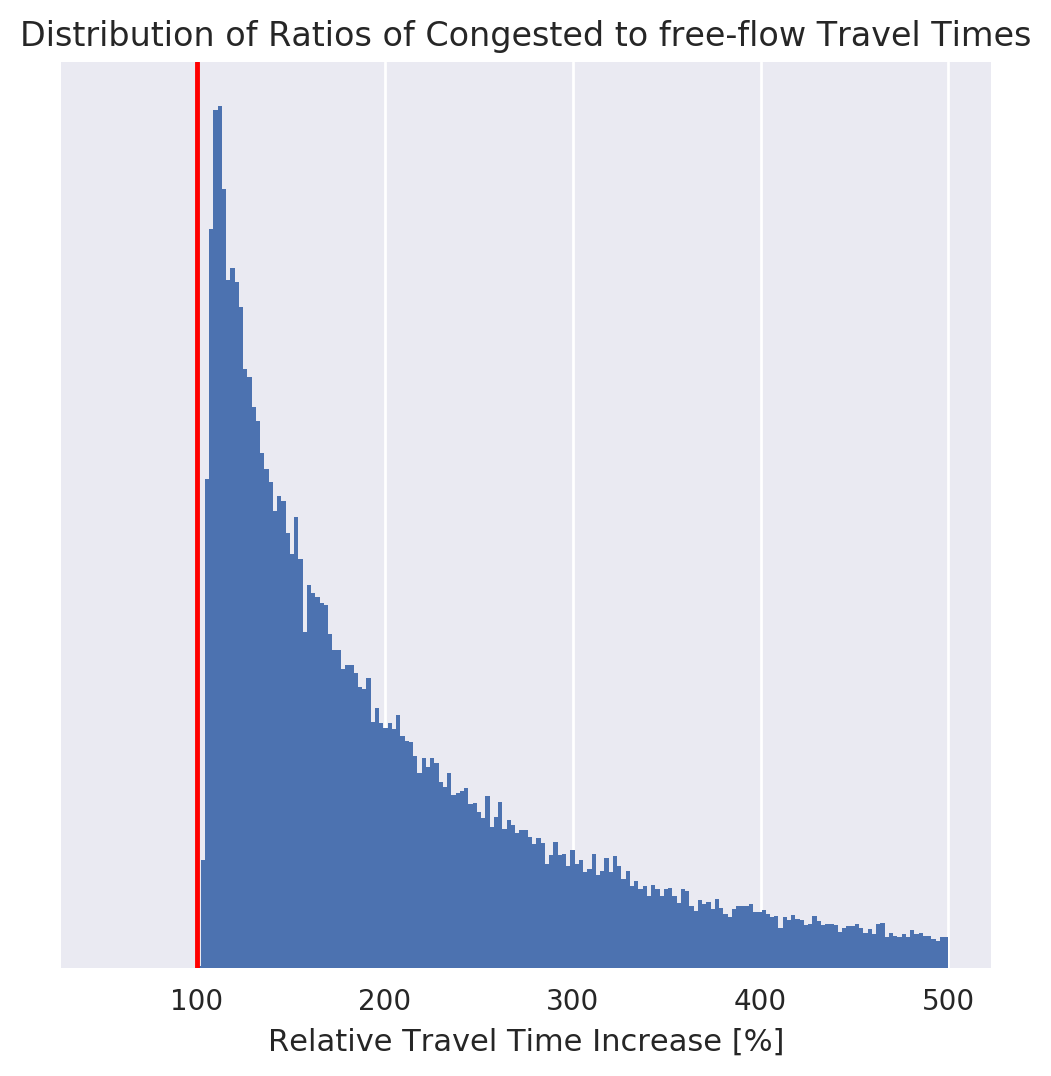

In [11]:
f = histogram_of_ratios(trips_original_freeflow_times, trips_original_higher_capacity, bins=np.linspace(0.5, 5, 200), 
                   title="Distribution of Ratios of Congested to free-flow Travel Times", nr="1c")

9745 trips were not matched
0.9386793933875475 percent of trips changed, mean: 1.1317442901030133, median: 1.0136693240927381


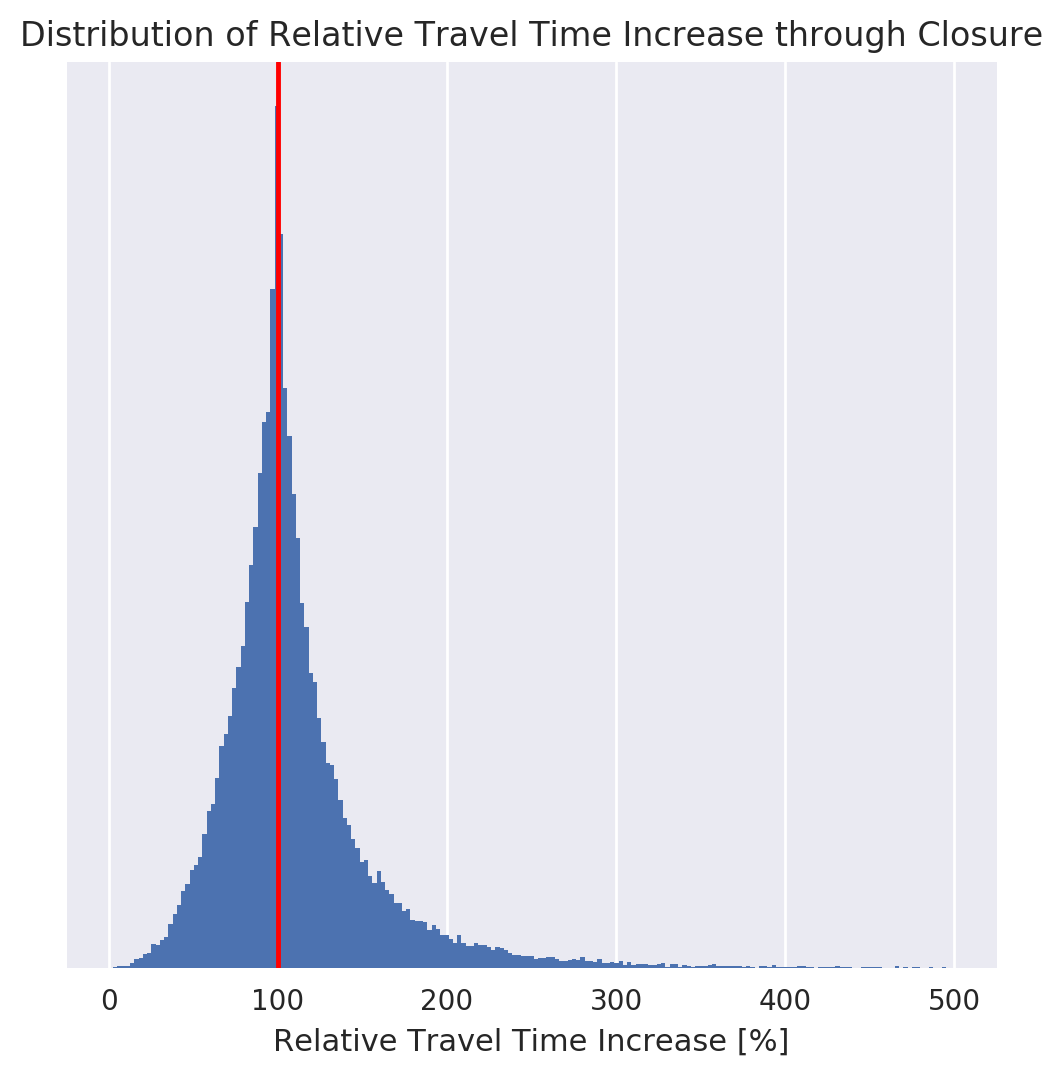

In [12]:
histogram_of_ratios(trips_original_higher_capacity, trips_slowed_down_roads, bins=np.linspace(0, 5, 200),
                   title="Distribution of Relative Travel Time Increase through Closure", nr="2b")

In [13]:
relevant_trips_original = trips_original_higher_capacity.loc[ids_of_trips_through_deleted_link.index]
relevant_trips_without_road = trips_slowed_down_roads.loc[ids_of_trips_through_deleted_link.index]
# relevant_trips_without_road == relevant_trips_original

print("{} of trips go through deleted road".format(len(relevant_trips_original)/len(trips_original_higher_capacity)))

0.023072889355007866 of trips go through deleted road


/Users/clemens/.pyenv/versions/3.6.6/envs/abmt_project/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


Mean: 42.5 minutes; Median: 38.2 minutes
Mean: 52.2 minutes; Median: 45.9 minutes


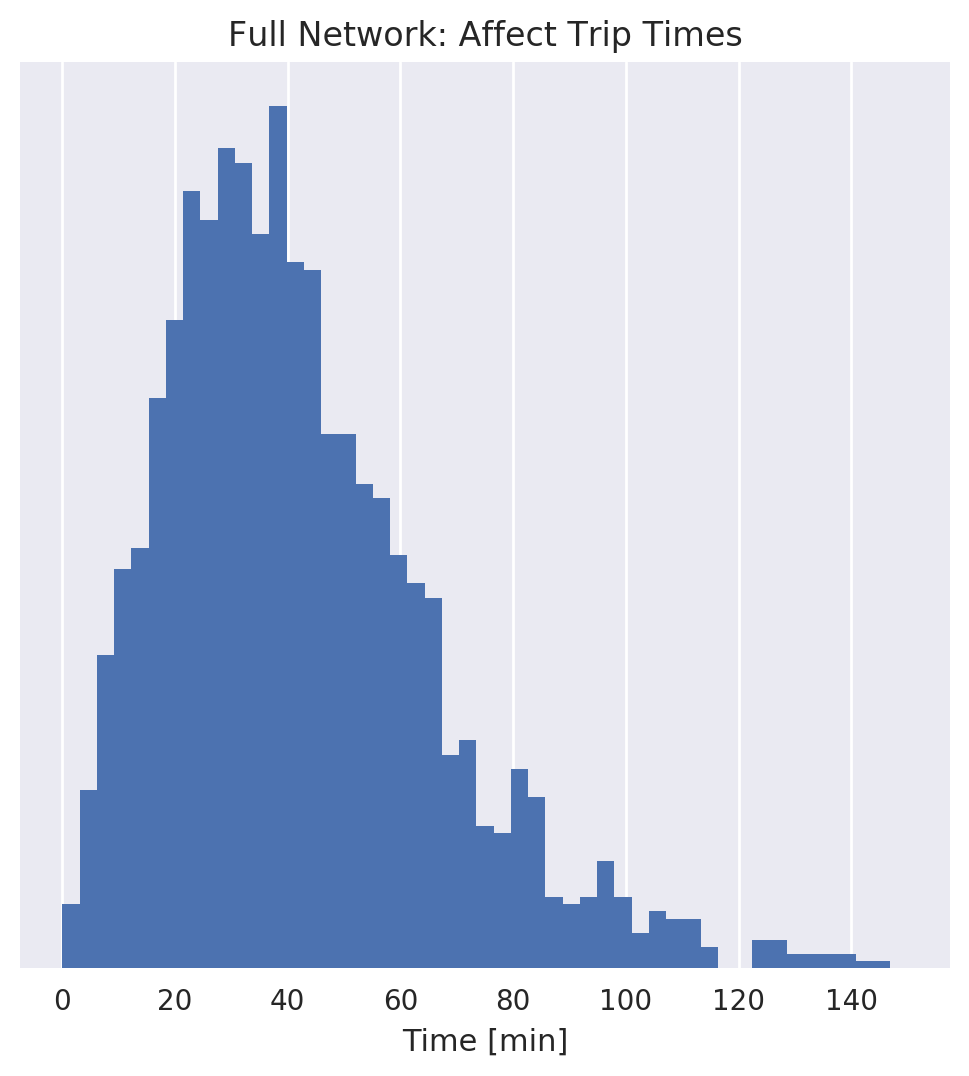

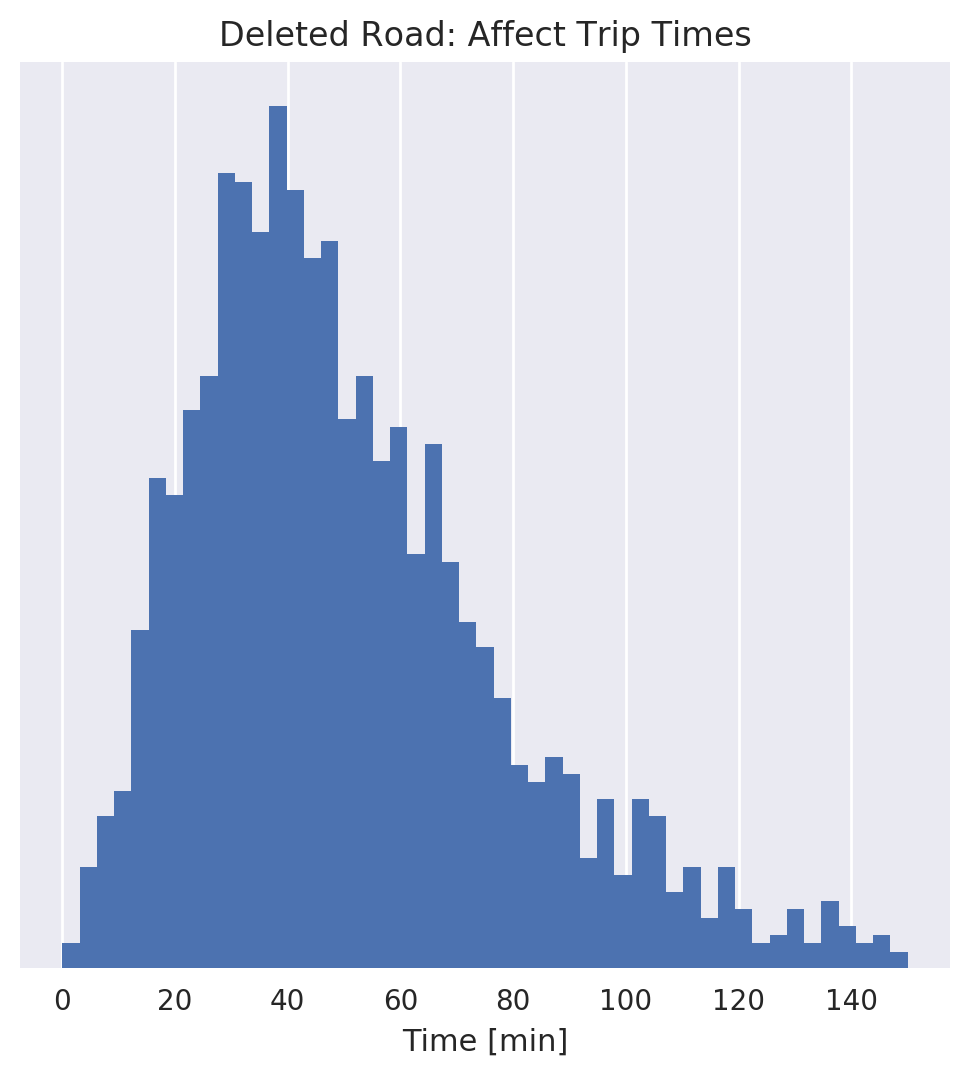

In [14]:
histogram_of_travel_times(relevant_trips_original, bins=np.linspace(0,150,50), 
                          title="Full Network: Affect Trip Times", nr="3a")

histogram_of_travel_times(relevant_trips_without_road, bins=np.linspace(0,150,50), 
                          title="Deleted Road: Affect Trip Times", nr="3b")

150 trips were not matched
0.9994400895856663 percent of trips changed, mean: 1.431988002608839, median: 1.1881720430107527


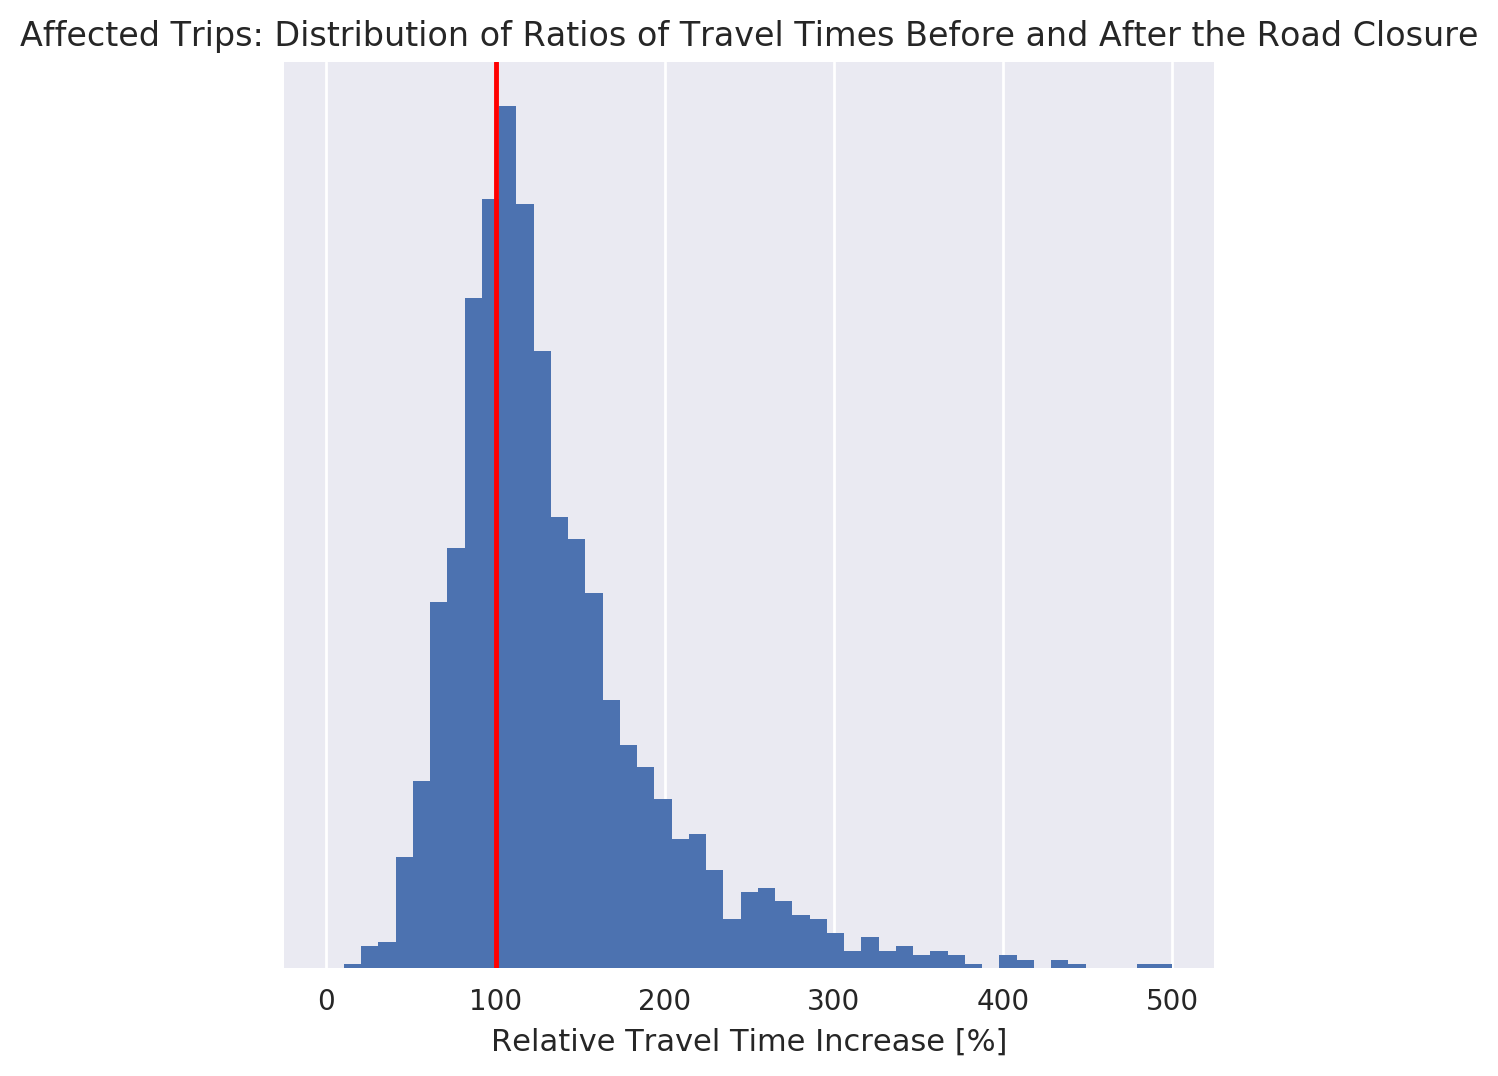

In [15]:
histogram_of_ratios(relevant_trips_original, relevant_trips_without_road, bins=np.linspace(0, 5, 50),
                    title="Affected Trips: Distribution of Ratios of Travel Times Before and After the Road Closure"
                     ,nr="3c"
                   )

In [16]:
trip = ids_of_trips_through_deleted_link.n_deleted_links.argmax()
print(ids_of_trips_through_deleted_link.loc[trip])
print(trips_original_higher_capacity.loc[trip])
print(trips_slowed_down_roads.loc[trip])

n_deleted_links    31
Name: 10033710@17:37:16, dtype: int64
person_id                                              10033710
dep_time                                               17:37:16
trav_time                                       0 days 00:56:34
start_link                                         78210-189508
end_link                                                 522826
route         78210-189508 189509 374971-68717 68718 525936 ...
Name: 10033710@17:37:16, dtype: object
person_id                                              10033710
dep_time                                               17:37:16
trav_time                                       0 days 01:52:08
start_link                                         78210-189508
end_link                                                 522826
route         78210-189508 78211 78214 466463-434993 19788 6...
Name: 10033710@17:37:16, dtype: object


/Users/clemens/.pyenv/versions/3.6.6/envs/abmt_project/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


# Plotting actuall routes

In [17]:
from shutil import rmtree
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import mplleaflet
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [18]:
network = gpd.GeoDataFrame.from_file("geopandas_original_network")
network.set_index('id', inplace=True)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
def make_cmap():
    cmap_name ="my_map"
    colors = [(1,0,0), (0.5,0.5,0.5), (0,1,0)]
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=3)
    return cm

from string import Template

def strfdelta(tdelta, fmt="{H:02d}:{M:02d}"):
#     print(tdelta)
    d = {"D": tdelta.days}
    d["H"], rem = divmod(tdelta.seconds, 3600)
    d["M"], d["S"] = divmod(rem, 60)
    return fmt.format(**d)

def compute_corners(route):
    alll=[(line.centroid.x, line.centroid.y) for line in route.geometry.values]
    x, y = zip(*alll)
    min_x = np.min(x)
    max_x = np.max(x)
    min_y = np.min(y)
    max_y = np.max(y)
    #return top_left, bottom_right
    return (min_x-500, max_y+500), (max_x+500, min_y-500)

def plot_two_trips(network, t1, t2, top_left=None, bottom_right=None): #top_left=(645000, 6868000), bottom_right=(658000, 6857000)):
    column_string = "tmp_trip_colour"
#     network.loc[:, column_string] = 0
    route1 = t1.route.split(" ")
    route2 = t2.route.split(" ")
    
    if top_left is None or bottom_right is None:
        top_left, bottom_right = compute_corners(network.loc[route1+route2])
    
#     network.loc[route1, column_string]=-1
#     network.loc[route2, column_string]=1
    base = network.plot(color='grey', linewidth=0.4)
    ax1 = network.loc[route1,:].plot(ax=base, color='red', linewidth=1)
    ax2 = network.loc[route2,:].plot(ax=ax1, color='green', linewidth=1)
#     ax = network.plot(column=column_string, cmap=cmap)
#     ax.set_xlim(645000,658000)
#     ax.set_ylim(6857000,6868000)
    ax2.set_xlim((top_left[0], bottom_right[0]))
    ax2.set_ylim((bottom_right[1], top_left[1]))
    title_string = "Departure {} | Travel Time Before: {} h, Travel Time After: {} h".format(
        t1.dep_time[:-3],
        strfdelta(t1.trav_time), strfdelta(t2.trav_time))
    print(title_string + " of {}@{}".format(t1.person_id, t1.dep_time))
    ax2.set_title(title_string)
    return base
    
def plot_two_trips_by_id(idd, network=network, all_trips1=trips_original_higher_capacity, all_trips2=trips_slowed_down_roads, top_left=None, bottom_right=None):
    t1 = all_trips1.loc[idd]
    t2 = all_trips2.loc[idd]
    return plot_two_trips(network, t1, t2, top_left=top_left, bottom_right=bottom_right)

# plot_two_trips(network, trips_original_higher_capacity.loc[trip], trips_slowed_down_roads.loc[trip], cmap=make_cmap(), top_left=(648000,6864500))

In [ ]:
def save_axis(ax, nr, title=None):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig = ax.get_figure()
    file_path = "{}/Figure {} - {}".format(output_figure_path, nr, title)
    fig.savefig(file_path)

In [ ]:
top_left = (648000,6864500)
bottom_right = (658000, 6857000)

top_overlapping_trips = ids_of_trips_through_deleted_link.iloc[np.argsort(ids_of_trips_through_deleted_link.n_deleted_links)[::-1]]

n=60
for trip_id in top_overlapping_trips.index[:n]:
    try:
        t1 = trips_original_higher_capacity.loc[trip_id]
        t2 = trips_slowed_down_roads.loc[trip_id]
        title_string = "{} _ Time Before: {}, Time After: {}".format(trip_id, strfdelta(t1.trav_time), strfdelta(t2.trav_time))
        print(title_string)
    except KeyError as e:
        print("the index {} is not found for some reason".format(trip_id))
        print(e)

plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi']=200

5522627@19:26:18 _ Time Before: 00:47, Time After: 01:01
10443428@22:42:25 _ Time Before: 00:29, Time After: 00:30
9057213@14:57:50 _ Time Before: 00:37, Time After: 00:35
10350976@24:56:15 _ Time Before: 00:17, Time After: 00:18
10350977@14:06:45 _ Time Before: 00:33, Time After: 00:59
1793909@21:17:01 _ Time Before: 00:25, Time After: 00:23
10351951@12:34:19 _ Time Before: 00:43, Time After: 01:18
889399@12:20:57 _ Time Before: 00:58, Time After: 01:00
225638@16:42:13 _ Time Before: 00:58, Time After: 00:43
8815948@16:02:38 _ Time Before: 00:48, Time After: 01:12
1380907@13:54:56 _ Time Before: 00:55, Time After: 01:00
1380907@08:39:56 _ Time Before: 00:52, Time After: 00:48
10365928@12:01:47 _ Time Before: 00:42, Time After: 00:36
the index 6956581@16:00:10 is not found for some reason
'the label [6956581@16:00:10] is not in the [index]'
10366369@11:35:35 _ Time Before: 00:29, Time After: 00:29
1787469@12:50:32 _ Time Before: 00:32, Time After: 00:55
8743466@11:41:49 _ Time Before: 

Departure 15:20 | Travel Time Before: 00:24 h, Travel Time After: 00:29 h of 10366369@15:20:35


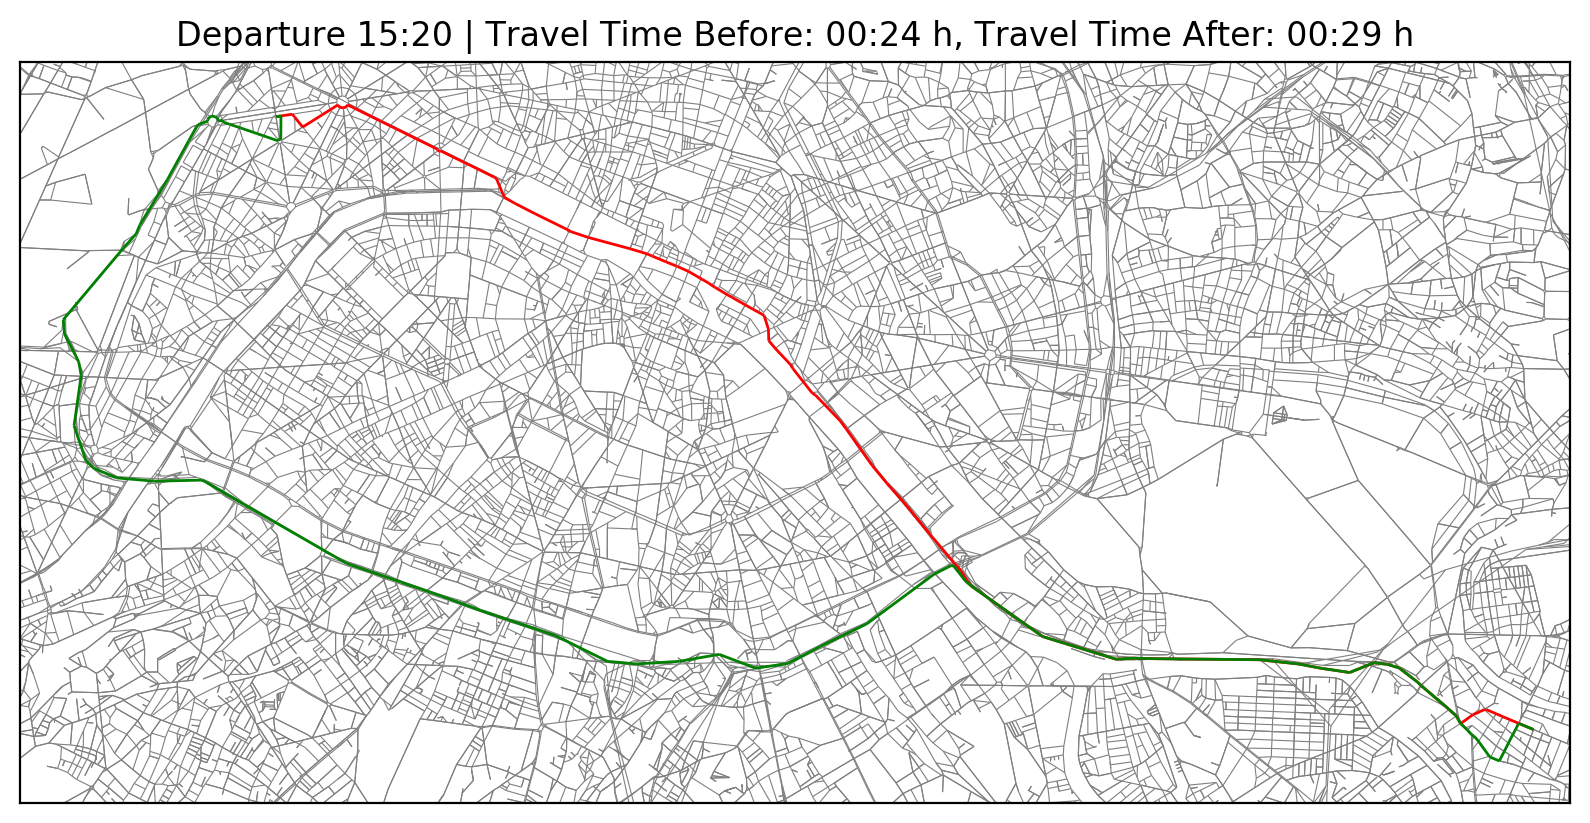

In [ ]:
ax = plot_two_trips_by_id("10366369@15:20:35")
save_axis(ax, nr="4c")

Departure 06:35 | Travel Time Before: 00:23 h, Travel Time After: 00:17 h of 422478@06:35:42


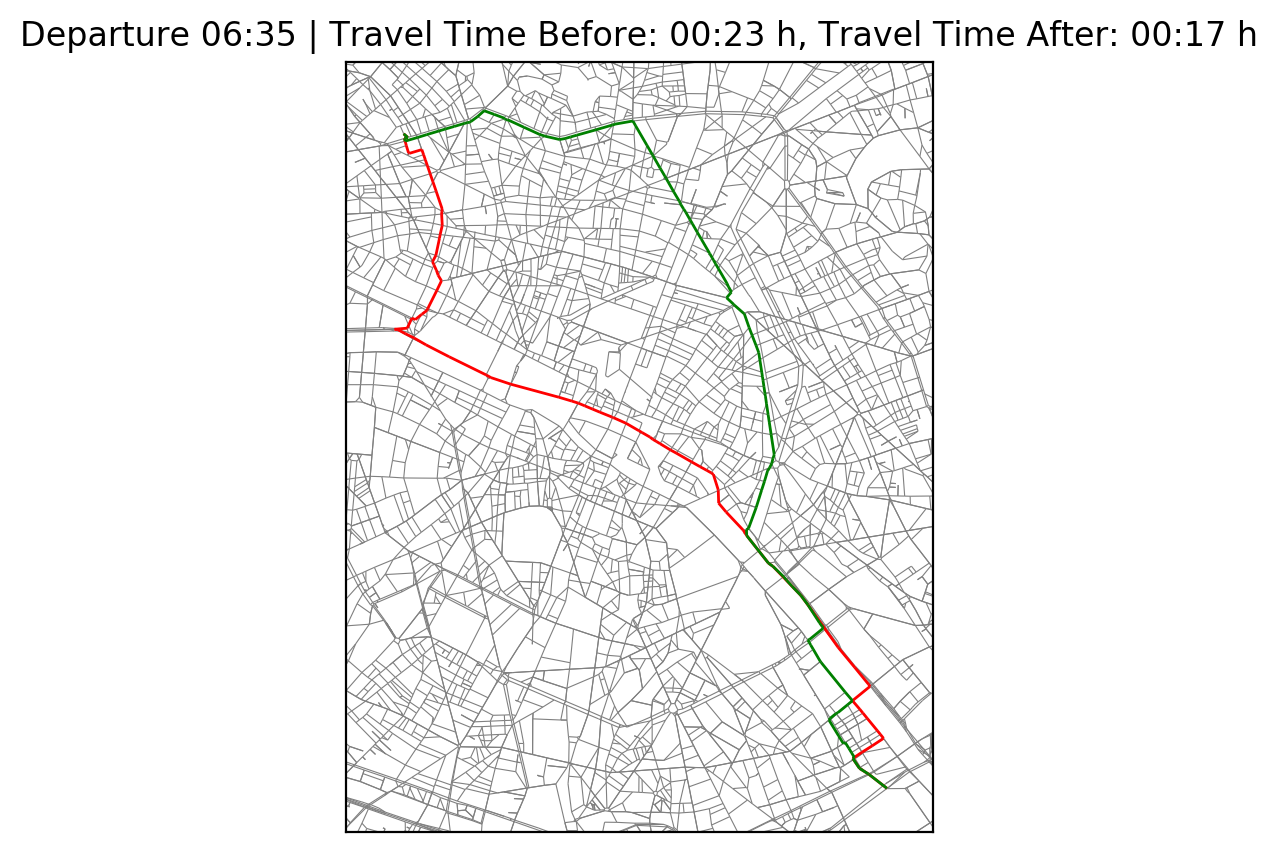

In [ ]:
ax = plot_two_trips_by_id("422478@06:35:42")
save_axis(ax, nr="4d")

In [ ]:
# save_axis(ax, nr="-1", title="test")

Departure 12:50 | Travel Time Before: 00:32 h, Travel Time After: 00:55 h of 1787469@12:50:32


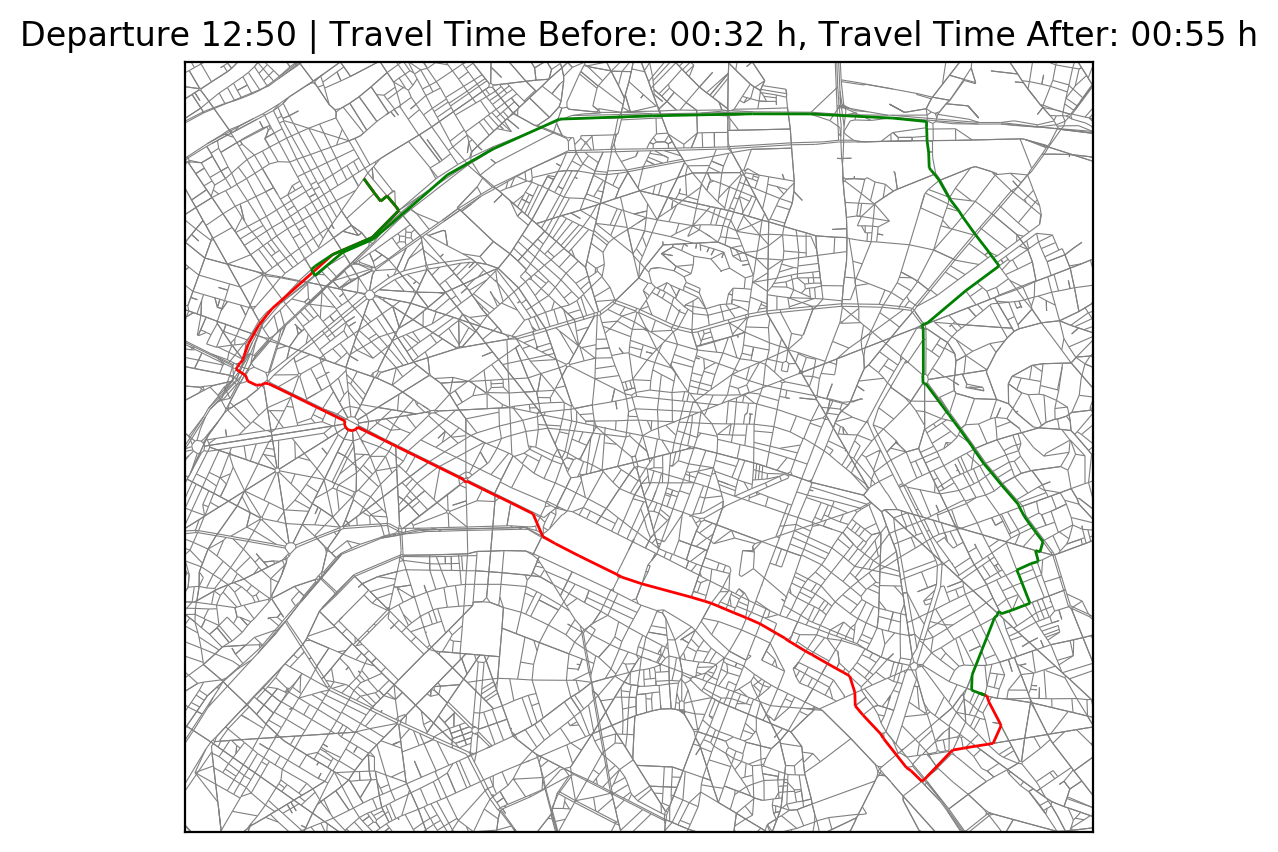

In [ ]:
ax = plot_two_trips_by_id("1787469@12:50:32")
save_axis(ax, nr="4a")

In [ ]:
# save_axis(ax, nr=)

Departure 13:22 | Travel Time Before: 00:22 h, Travel Time After: 00:45 h of 9261677@13:22:50


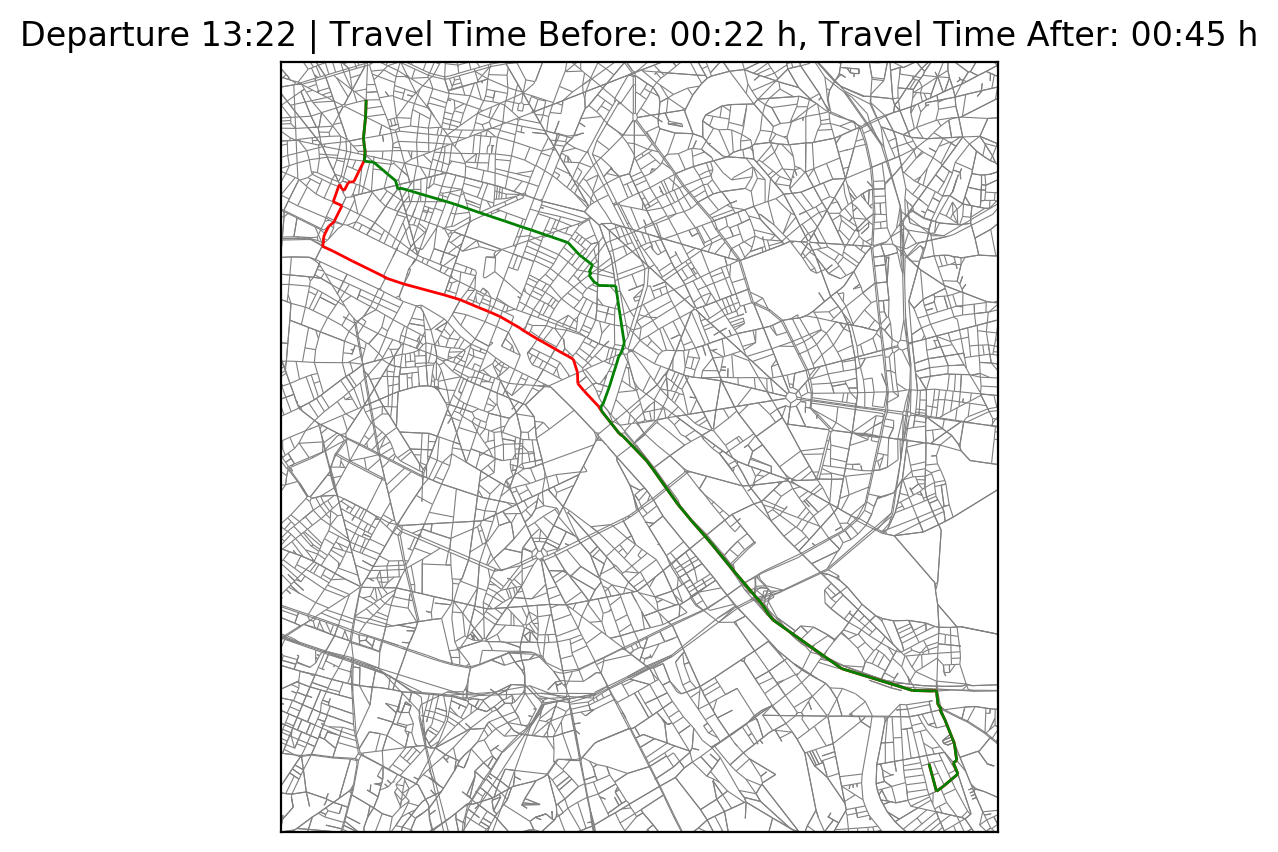

In [ ]:
ax = plot_two_trips_by_id("9261677@13:22:50")
save_axis(ax, nr="4b")

Departure 19:40 | Travel Time Before: 00:38 h, Travel Time After: 00:57 h of 9372693@19:40:59


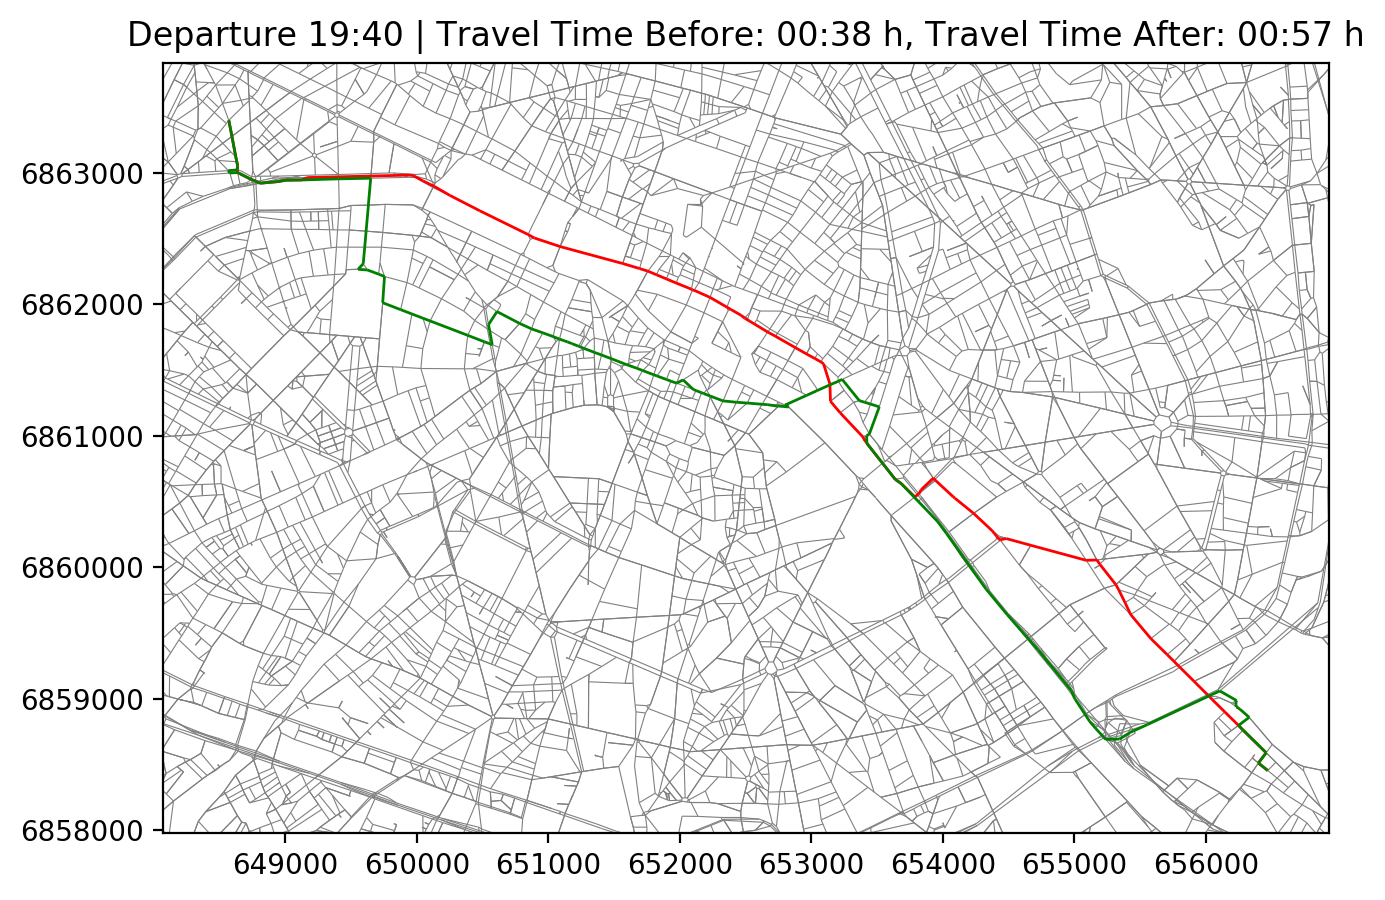

In [ ]:
ax = plot_two_trips_by_id("9372693@19:40:59")

In [ ]:
# mplleaflet.display(fig=ax.figure, crs=network.crs, tiles='esri_natgeo')

In [ ]:
n=8
for trip_id in top_overlapping_trips.index[:n]:
    try:
        t1 = trips_original_higher_capacity.loc[trip_id]
        t2 = trips_slowed_down_roads.loc[trip_id]
        plot_two_trips(network, t1, t2, top_left=top_left, bottom_right=bottom_right)
    except KeyError as e:
        print("the index {} is not found for some reason".format(trip_id))
        print(e)

Departure 19:26 | Travel Time Before: 00:47 h, Travel Time After: 01:01 h of 5522627@19:26:18
Departure 22:42 | Travel Time Before: 00:29 h, Travel Time After: 00:30 h of 10443428@22:42:25
Departure 14:57 | Travel Time Before: 00:37 h, Travel Time After: 00:35 h of 9057213@14:57:50
Departure 24:56 | Travel Time Before: 00:17 h, Travel Time After: 00:18 h of 10350976@24:56:15
